[ 생각해보기 ]

상품명 : 일시불, 무이자로 나누기, 무), (무), (일) 
--

=> 일시불, 무이자의 전체 합, 평균은 편성 횟수 및 시기가 비슷하고, 제품의 가격 또한 같다

=> 제품을 사야겠다고 생각한 뒤 가장 최종적으로 결정하는 요소임

=> 무이자라고, 일시불이라고 제품을 사는게 아니다 !!!!!

=> 같은 상품에 대해 일시불, 무이자가 영향을 미치는지는 모델링을 해봐야 알 것 같다


브랜드(마더코드) 활용 
-- 
=> 브랜드 파워를 고려해줄 수 있을까 ? 

=> 마더코드별 취급액 확인 후, 취급액의 범위에 따라 / 판매단가 범위에 따라 범주화해보자  



초특가(328), 파격가(99), 100%(59) 등등
--

=> 같은 상품인데 상품명에 '단어'가 붙음에 따라 취급액에 변화가 있는지 확인 필요

=> 판매 단가의 변동이 있을 수도 있기 때문에 이것도 같이 확인해주자 


국내산(861) // 햇(185) // 손질(979) // 자연산(135)
--

=> 좋은거 먹자!는 마음! 

=> 같은 상품코드에 대해 국내산 / 아닌 것 의 비교

비교하고자 하는 게 같은 품목에 대한 국내산 or not 인지, 같은 제품에 대해 상품명 국내산 표기 or not인지 명확히 하기( 확인해야함 )


여행 + 투어 
--

=> 작년은 많았을텐데 올해는 없을 것으로 예상...............

=> 데이터를 아예 빼는게 좋지 않을까?????? 라는 생각이 든다아

=> 상품명에 회사 + 제품이 있는데 회사(참좋은여행)에서 호텔 을 판매할 수도 있지 않나????( 확인해야함 )


무료(227) / 체험(42)
--

=> 이런 키워드가 어떤 영향이 있을지???????????




1+1 , 세트 / 6인용, 10인용
--

=> 해보고 싶은데 종류가 너무 많아............. 제일 마지막에 해보장

# 데이터 정제

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import time

# 한글 폰트 설정

fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
plt.rc('font', size=20)

# 지수 표현 안보기


In [12]:
# 데이터 로드
data = pd.read_csv('data/train.csv', encoding='cp949', header=0, parse_dates=["방송일시"])

# 상품군 = 무형 제거 

data.drop(data[data['상품군']=='무형'].index, inplace=True)
data.reset_index(inplace=True)


# 판매단가, 취급액 쉼표 제거 , int 변환

data['판매단가'] = data['판매단가'].str.replace(',','').astype(int)
data[' 취급액 '] = data[' 취급액 '].str.replace(',','').astype(int)
data['노출(분)'] = data['노출(분)'].astype(int)


# 방송일시 column 분리 ( , 일, 시, 분, 요일 )

data['방송일시'] = pd.to_datetime(data['방송일시'], format='%Y-%m-%d %H:%M:%S', errors='raise')

data['month'] = data['방송일시'].dt.month
data['day'] = data['방송일시'].dt.day
data['hour'] = data['방송일시'].dt.hour
data['minute'] = data['방송일시'].dt.minute
data['요일'] = data['방송일시'].dt.weekday

# 06 ~ 익일 02 가 한 cycle임을 고려하여 0, 1, 2 에 +24를 해주자

# def plus_24(x) :
#     if x in [0, 1, 2] :
#         return x + 24
#     else :
#         return x
    
# data['hour'] = list(map(plus_24, data['hour']))
overnight_index_list = data.loc[(data["hour"] >=0) & (data["hour"] < 3)].index

overnight_index_list
data.loc[overnight_index_list, "hour"] += 24
data.loc[overnight_index_list, "day"] -= 1
data.loc[overnight_index_list, "요일"] -= 1
data.loc[data["요일"] == -1, "요일"] = 6

### 엑셀에서 수정필요
# day = 0 인 곳, 그 전달의 마지막 날짜로 변경해주기
# month, day 변경 필요
# 2월은 28일까지
# 연말 12 / 31

In [13]:
# use data
df = data.loc[:,['month','day','hour','minute','요일','상품군','마더코드','상품코드','상품명','노출(분)','판매단가',' 취급액 ']]


# 무이자, 일시불을 나타내는 단어 통일
def replace_word(x) :
    if '무)'in x :
        return x.replace('무)', '무이자')
    elif '일)' in x :
        return x.replace('일)', '일시불')
    else :
        return x
    
df['상품명'] = list(map(replace_word, df['상품명'])) 

# 일시불 = 1, 무이자 = 2 로 하는 column 생성
new = []
for i in range(len(df['상품명'])) :
    if '일시불' in df['상품명'][i] :
        df['상품명'][i] = df['상품명'][i].replace('일시불','')
        new.append(1)
    elif '무이자' in df['상품명'][i] :
        df['상품명'][i] = df['상품명'][i].replace('무이자','')
        new.append(2)
    else :
        new.append(0)

df['pay_type'] = pd.DataFrame(new)

# 이외에 '특정단어'를 포함한 상품명에 대해 분석하고 싶은 경우
def make_new_col(word) :
    new = []
    for i in range(len(df['상품명'])) :
        if word in df['상품명'][i] :
            df['상품명'][i] = df['상품명'][i].replace(word,'')
            new.append(1)
        else :
            df['상품명'][i] = df['상품명'][i].replace(word,'')
            new.append(0)
    df[word] = pd.DataFrame(new)
    return df

#make_new_col('햇')
#make_new_col('초특가')
#make_new_col('국내산')
#make_new_col('무료')

# 엑셀로 저장, 월일 변경하는거 잊지말기 !!!
# df.to_csv('./analysis/tmp.csv', index=False, encoding='cp949')



C:\python\envs\cpu_env\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\python\envs\cpu_env\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
df = pd.read_csv('./data/train2.csv', encoding='cp949', header=0)
df

,month,day,hour,minute,노출(분),상품코드,상품명,판매단가,취급액,요일,상품군,마더코드,pay_type
0,1,1,6,0,20,201072,테이트 남성 셀린니트3종,39900,2099000,1,의류,100346,0
1,1,1,6,0,20,201079,테이트 여성 셀린니트3종,39900,4371000,1,의류,100346,0
2,1,1,6,20,20,201072,테이트 남성 셀린니트3종,39900,3262000,1,의류,100346,0
3,1,1,6,20,20,201079,테이트 여성 셀린니트3종,39900,6955000,1,의류,100346,0
4,1,1,6,40,20,201072,테이트 남성 셀린니트3종,39900,6672000,1,의류,100346,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,12,31,23,40,20,201391,쿠첸압력밥솥 6인용,148000,10157000,1,주방,100448,1
37368,12,31,24,0,20,201383,쿠첸압력밥솥 10인용,178000,50929000,1,주방,100448,2
37369,12,31,24,0,20,201390,쿠첸압력밥솥 10인용,168000,104392000,1,주방,100448,1
37370,12,31,24,0,20,201384,쿠첸압력밥솥 6인용,158000,13765000,1,주방,100448,2


# 상품명에 있는 키워드로 살펴보자

## 햇


* 특정 키워드를 추출해서 어떤걸 확인해보지 ???

- 노출시간에 따라 취급액을 확인했더니 11분일 때 취급액이 매우크다.

-> 확인 결과 '햇' 단어 확인
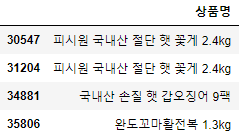

->  '햇' 단어가 든 상품 / 아닌 것 비교해보자

---
---
---
---
---
노출시간을 먼저 합해줘야하나 ????? pending !!!!!!!!

In [10]:
idx = []
for i in range(len(df['상품명'])) : 
    if '햇' in df['상품명'][i] :
        idx.append(i)

# '햇'글자 포함(185row)
print(df.iloc[idx].mean())
# '햇'글자 제외
print(df.drop(idx).mean())


## 주의 : '햇' 단어에 햇반?과 같은 단어 있는지 확인 (test set)
## 결과 : 판매단가가 비슷, 노출시간은 '햇' 단어 제외가 더 많음, 취급액은 '햇'포함이 훨씬 높음
## + ) 당연한 것 같기도하고 ???????????????????
## 아닌가????????????

month       1.044324e+01
day         1.736216e+01
hour        1.690811e+01
minute      1.967568e+01
요일          3.383784e+00
마더코드        1.003487e+05
상품코드        2.013257e+05
노출(분)       1.962162e+01
판매단가        4.990000e+04
 취급액        6.551279e+07
pay_type    0.000000e+00
dtype: float64
month       6.443461e+00
day         1.527676e+01
hour        1.630594e+01
minute      2.007287e+01
요일          3.015973e+00
마더코드        1.003897e+05
상품코드        2.012113e+05
노출(분)       2.038546e+01
판매단가        4.700806e+05
 취급액        2.165595e+07
pay_type    5.793422e-01
dtype: float64


## 국내

In [157]:
idx = []
for i in range(len(df['상품명'])) : 
    if '국내' in df['상품명'][i] :
        idx.append(i)

# '국내'글자 포함(861row)
print(df.iloc[idx].mean())
# '국내'글자 제외
print(df.drop(idx).mean())


month       7.663182e+00
day         1.612311e+01
hour        1.658653e+01
minute      1.995354e+01
노출(분)       1.980720e+01
상품코드        2.014426e+05
판매단가        1.114094e+05
 취급액        4.186980e+07
요일          3.011614e+00
마더코드        1.004164e+05
pay_type    2.229965e-01
new_idx              inf
dtype: float64
month       6.434198e+00
day         1.533031e+01
hour        1.630237e+01
minute      2.007368e+01
노출(분)       2.039522e+01
상품코드        2.012064e+05
판매단가        4.764097e+05
 취급액        2.140149e+07
요일          3.017940e+00
마더코드        1.003889e+05
pay_type    5.848101e-01
new_idx              inf
dtype: float64


## 손질

In [160]:
idx = []
for i in range(len(df['상품명'])) : 
    if '손질' in df['상품명'][i] :
        idx.append(i)

# '손질'글자 포함(861row)
print(df.iloc[idx].mean())
# '손질'글자 제외
print(df.drop(idx).mean())

month       6.236977e+00
day         1.565679e+01
hour        1.654545e+01
minute      2.006129e+01
노출(분)       1.983555e+01
상품코드        2.014663e+05
판매단가        4.786834e+04
 취급액        4.990134e+07
요일          3.006129e+00
마더코드        1.004332e+05
pay_type    0.000000e+00
new_idx              inf
dtype: float64
month       6.468579e+00
day         1.534029e+01
hour        1.630256e+01
minute      2.007117e+01
노출(분)       2.039637e+01
상품코드        2.012050e+05
판매단가        4.793025e+05
 취급액        2.111907e+07
요일          3.018108e+00
마더코드        1.003883e+05
pay_type    5.919820e-01
new_idx              inf
dtype: float64


# 노출 시간 ( 같은 제품 하루에 4번 이상 노출 )

같은 제품을 연속적으로 방송해서 편성표에 3번 * 2번 배치된 것도 있고 : 3 / 22 . 200889 ( 20분씩 편성됨 )

같은 제품인데 시간을 다르게 해서 편성표에 6번 로 배치된 것도 있다 : 12 / 22 , 200153 ( 10분씩 편성됨 )

month, day가 같은데 상품코드가 같다면 ? ( 여기에 일시불 , 무이자 / 몇인용 그런거 다 포함 된거임 )

=> 이걸로 하면 안됨 => 하루에 상품을 여러 시간대에 배치하는 경우가 있음

## 노출(분) 데이터 뜯어보자

In [5]:
## 단순 편성 개수 ( 연달아 있는거 있음 주의 )
df['노출(분)'].value_counts()

20    33057
30     2625
10      813
15      453
17      161
16      117
13       67
26       12
25       11
23        9
18        6
7         6
3         6
12        5
5         5
22        4
11        4
19        3
27        2
14        2
40        2
9         1
2         1
Name: 노출(분), dtype: int64

In [8]:
# 편성 개수 대비 취급액 평균이 높은 것
df[' 취급액 '].groupby(df['노출(분)']).mean().sort_values(ascending=False)

노출(분)
11    5.644025e+07
18    2.792483e+07
27    2.589550e+07
20    2.228159e+07
30    2.144906e+07
19    2.139367e+07
7     1.809683e+07
10    1.699862e+07
14    1.680200e+07
22    1.668525e+07
17    1.485490e+07
13    1.269301e+07
26    1.165175e+07
15    1.132159e+07
23    1.107933e+07
2     1.073100e+07
12    1.070180e+07
40    1.014050e+07
3     1.013067e+07
25    9.765273e+06
16    9.693538e+06
5     7.447000e+06
9     9.710000e+05
Name:  취급액 , dtype: float64

In [13]:
df.loc[df['노출(분)']==11]

,month,day,hour,minute,노출(분),상품코드,상품명,판매단가,취급액,요일,상품군,마더코드,pay_type
30547,10,20,16,40,11,201486,피시원 국내산 절단 햇 꽃게 2.4kg,49900,53796000,6,농수축,100492,0
31204,10,27,16,40,11,201486,피시원 국내산 절단 햇 꽃게 2.4kg,49900,82924000,6,농수축,100492,0
34881,12,5,21,0,11,201004,국내산 손질 햇 갑오징어 9팩,49900,47069000,3,농수축,100317,0
35806,12,14,17,20,11,201634,완도꼬마활전복 1.3kg,29900,41972000,5,농수축,100548,0


In [14]:
# 취급액 최대값인 노출시간
df[' 취급액 '].groupby(df['노출(분)']).max().sort_values(ascending=False)

노출(분)
17    322009000
20    270284000
30    153959000
13    108590000
10     84950000
11     82924000
18     76905000
7      63269000
15     55655000
16     41859000
25     33264000
3      30798000
27     29034000
26     26273000
19     24885000
22     24475000
23     22171000
12     20502000
14     17818000
40     16770000
5      16426000
2      10731000
9        971000
Name:  취급액 , dtype: int64

In [12]:
df.loc[df['노출(분)']==17]

,month,day,hour,minute,노출(분),상품코드,상품명,판매단가,취급액,요일,상품군,마더코드,pay_type
66,1,1,25,40,17,200652,레이프릴 무빙 맥시풀커버 브라팬티,69900,18695000,1,속옷,100193,0
170,1,2,25,40,17,201894,푸마 웜셀 기모 치마레깅스 3종,59000,24910000,2,속옷,100613,0
265,1,3,25,40,17,200800,벨라홈 논슬립 옷걸이 세트,29800,20974000,3,생활용품,100229,0
349,1,4,25,40,17,200952,[가이거] 제니스시계 주얼리세트,129000,20633000,4,잡화,100293,1
350,1,4,25,40,17,200949,[가이거] 제니스시계 주얼리세트,139000,8495000,4,잡화,100293,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36965,12,26,25,40,17,201006,블랙모어스 알티지 오메가3 3병 (53주분),95200,9804000,3,건강기능,100312,0
37040,12,27,25,40,17,202484,옛날 그 쥐포 110장 (11팩),32900,29330000,4,농수축,100841,0
37131,12,28,25,40,17,202114,아이앤아이 퀵래쉬 속눈썹세트,59000,20588000,5,이미용,100723,0
37209,12,29,25,40,17,201021,코이모 리빙박스 8종,50800,18854000,6,생활용품,100226,0


In [19]:
df.loc[df['노출(분)']==17].sort_values(by=' 취급액 ', ascending=False)
## 이상치로 봐야할까 ? 34988(max), 32564(min)

,month,day,hour,minute,노출(분),상품코드,상품명,판매단가,취급액,요일,상품군,마더코드,pay_type
34988,12,6,25,40,17,201322,코몽트 덤블 플리스 자켓 2종,39900,322009000,4,의류,100418,0
28746,10,2,25,40,17,201367,쿠미투니카 롱 하이웨스트 팬티세트,59900,38910000,2,속옷,100444,0
36061,12,16,25,40,17,200897,헤스티지 엘레나 라쿤양가죽 콤비 롱코트,299000,32763000,0,의류,100271,0
33132,11,16,25,40,17,202484,옛날 그 쥐포 110장 (11팩),32900,30877000,5,농수축,100841,0
35094,12,7,25,40,17,200666,오델로 여성 겨울모자 3종,29800,30464000,5,잡화,100197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33831,11,24,25,40,17,201326,킹스스파 편백 반신욕기,569000,1869000,6,생활용품,100421,0
35239,12,8,25,40,17,202081,아미니 비노테라 오일 워시(구성2),59900,944000,6,이미용,100711,0
36438,12,20,25,40,17,201874,푸마 드라이셀 쉐이핑 레깅스 3종,59000,607000,4,속옷,100613,0
35095,12,7,25,40,17,200665,오델로 남성 겨울모자 3종,29800,426000,5,잡화,100197,0


## 노출(분)과 편성 개수 관계 

In [4]:
tmp = df.groupby(['month','day','상품코드']).sum()[' 취급액 ']
tmp2 = df.groupby(['month','day','상품코드']).count()[' 취급액 ']

In [76]:
x = []
for i in tmp.index :
    print('취급액 : ', tmp[i], '개수 : ', tmp2[i])
    if tmp2[i] in [4,5,6,8,9,10,12] : 
        x.append(i)
        if tmp2[i] == 6:
            print('------------------------------------------------',i)

# tmp[x].to_excel('./analysis/하루안에상품여러번판매.xlsx', encoding='cp949')

취급액 :  222836000 개수 :  3
취급액 :  192141000 개수 :  3
취급액 :  123876000 개수 :  3
취급액 :  160698000 개수 :  3
취급액 :  43858000 개수 :  3
취급액 :  115831000 개수 :  2
취급액 :  111546000 개수 :  2
취급액 :  47878000 개수 :  3
취급액 :  12033000 개수 :  3
취급액 :  20663000 개수 :  3
취급액 :  51795000 개수 :  2
취급액 :  34528000 개수 :  3
취급액 :  68135000 개수 :  2
취급액 :  25577000 개수 :  3
취급액 :  246455000 개수 :  3
취급액 :  176244000 개수 :  2
취급액 :  86177000 개수 :  3
취급액 :  190579000 개수 :  3
취급액 :  74360000 개수 :  2
취급액 :  154715000 개수 :  3
취급액 :  122537000 개수 :  3
취급액 :  99736000 개수 :  3
취급액 :  259678000 개수 :  3
취급액 :  90973000 개수 :  3
취급액 :  83893000 개수 :  1
취급액 :  10574000 개수 :  3
취급액 :  30986000 개수 :  3
취급액 :  14623000 개수 :  3
취급액 :  47841000 개수 :  3
취급액 :  12659000 개수 :  3
취급액 :  82649000 개수 :  3
취급액 :  150000 개수 :  3
취급액 :  61526000 개수 :  3
취급액 :  35241000 개수 :  3
취급액 :  101053000 개수 :  3
취급액 :  155211000 개수 :  3
취급액 :  96155000 개수 :  2
취급액 :  85256000 개수 :  2
취급액 :  67533000 개수 :  3
취급액 :  70951000 개수 :  3
취급액 :  17810000 개수 :  2
취급액 

취급액 :  10429000 개수 :  3
취급액 :  14598000 개수 :  3
취급액 :  22065000 개수 :  3
취급액 :  64322000 개수 :  3
취급액 :  19714000 개수 :  3
취급액 :  139820000 개수 :  3
취급액 :  181784000 개수 :  3
취급액 :  27559000 개수 :  3
취급액 :  62174000 개수 :  3
취급액 :  39937000 개수 :  3
취급액 :  45985000 개수 :  3
취급액 :  79283000 개수 :  2
취급액 :  153048000 개수 :  3
취급액 :  36761000 개수 :  3
취급액 :  17662000 개수 :  3
취급액 :  7174000 개수 :  3
취급액 :  21881000 개수 :  3
취급액 :  4272000 개수 :  3
취급액 :  6711000 개수 :  3
취급액 :  83569000 개수 :  3
취급액 :  15543000 개수 :  3
취급액 :  26634000 개수 :  3
취급액 :  150009000 개수 :  3
취급액 :  59094000 개수 :  3
취급액 :  69252000 개수 :  3
취급액 :  164073000 개수 :  2
취급액 :  24143000 개수 :  3
취급액 :  17175000 개수 :  3
취급액 :  77571000 개수 :  3
취급액 :  120520000 개수 :  3
취급액 :  81493000 개수 :  3
취급액 :  24539000 개수 :  3
취급액 :  19839000 개수 :  3
취급액 :  71107000 개수 :  3
취급액 :  160085000 개수 :  3
취급액 :  108450000 개수 :  3
취급액 :  188550000 개수 :  3
취급액 :  198506000 개수 :  3
취급액 :  39341000 개수 :  2
취급액 :  14041000 개수 :  3
취급액 :  46454000 개수 :  3
취급액 :  15

취급액 :  17983000 개수 :  3
취급액 :  35215000 개수 :  3
취급액 :  62795000 개수 :  3
취급액 :  25173000 개수 :  3
취급액 :  71390000 개수 :  3
취급액 :  5821000 개수 :  3
취급액 :  64294000 개수 :  3
취급액 :  124886000 개수 :  3
취급액 :  37950000 개수 :  3
취급액 :  9285000 개수 :  3
취급액 :  70175000 개수 :  3
취급액 :  28847000 개수 :  3
취급액 :  32091000 개수 :  3
취급액 :  78072000 개수 :  3
취급액 :  49674000 개수 :  3
취급액 :  15912000 개수 :  3
취급액 :  14432000 개수 :  3
취급액 :  38413000 개수 :  3
취급액 :  130338000 개수 :  3
취급액 :  133088000 개수 :  3
취급액 :  16230000 개수 :  3
취급액 :  65407000 개수 :  3
취급액 :  43809000 개수 :  3
취급액 :  7676000 개수 :  3
취급액 :  95341000 개수 :  3
취급액 :  47113000 개수 :  3
취급액 :  59529000 개수 :  3
취급액 :  72190000 개수 :  3
취급액 :  116708000 개수 :  3
취급액 :  28742000 개수 :  3
취급액 :  169591000 개수 :  3
취급액 :  192344000 개수 :  3
취급액 :  28910000 개수 :  3
취급액 :  14598000 개수 :  3
취급액 :  30979000 개수 :  3
취급액 :  48202000 개수 :  3
취급액 :  16128000 개수 :  3
취급액 :  13792000 개수 :  3
취급액 :  14625000 개수 :  3
취급액 :  33708000 개수 :  3
취급액 :  28768000 개수 :  3
취급액 :  223520

취급액 :  7884000 개수 :  3
취급액 :  56396000 개수 :  3
취급액 :  6268000 개수 :  3
취급액 :  26736000 개수 :  3
취급액 :  9227000 개수 :  3
취급액 :  14625000 개수 :  3
취급액 :  46204000 개수 :  3
취급액 :  14167000 개수 :  3
취급액 :  56631000 개수 :  3
취급액 :  2320000 개수 :  3
취급액 :  69614000 개수 :  3
취급액 :  101687000 개수 :  3
취급액 :  33312000 개수 :  3
취급액 :  31870000 개수 :  3
취급액 :  24153000 개수 :  3
취급액 :  2121000 개수 :  3
취급액 :  99273000 개수 :  3
취급액 :  12373000 개수 :  3
취급액 :  75722000 개수 :  3
취급액 :  66239000 개수 :  3
취급액 :  49900000 개수 :  3
취급액 :  75160000 개수 :  3
취급액 :  34243000 개수 :  2
취급액 :  59763000 개수 :  3
취급액 :  105277000 개수 :  3
취급액 :  102329000 개수 :  3
취급액 :  57737000 개수 :  3
취급액 :  127516000 개수 :  3
취급액 :  136468000 개수 :  3
취급액 :  92009000 개수 :  3
취급액 :  56381000 개수 :  3
취급액 :  12048000 개수 :  3
취급액 :  35583000 개수 :  3
취급액 :  27961000 개수 :  3
취급액 :  6492000 개수 :  3
취급액 :  84948000 개수 :  3
취급액 :  24110000 개수 :  3
취급액 :  126528000 개수 :  3
취급액 :  23515000 개수 :  3
취급액 :  18036000 개수 :  3
취급액 :  24336000 개수 :  3
취급액 :  19277000 

취급액 :  81007000 개수 :  3
취급액 :  109501000 개수 :  3
취급액 :  70594000 개수 :  3
취급액 :  44042000 개수 :  3
취급액 :  24552000 개수 :  3
취급액 :  16319000 개수 :  3
취급액 :  105179000 개수 :  3
취급액 :  108068000 개수 :  3
취급액 :  44270000 개수 :  2
취급액 :  33723000 개수 :  2
취급액 :  76631000 개수 :  3
취급액 :  14705000 개수 :  3
취급액 :  11811000 개수 :  3
취급액 :  12608000 개수 :  3
취급액 :  13292000 개수 :  3
취급액 :  101636000 개수 :  3
취급액 :  59388000 개수 :  3
취급액 :  61422000 개수 :  3
취급액 :  105701000 개수 :  3
취급액 :  91388000 개수 :  3
취급액 :  45901000 개수 :  3
취급액 :  17003000 개수 :  3
취급액 :  12543000 개수 :  3
취급액 :  33825000 개수 :  3
취급액 :  126268000 개수 :  3
취급액 :  21989000 개수 :  2
취급액 :  1773000 개수 :  3
취급액 :  26745000 개수 :  3
취급액 :  1660000 개수 :  3
취급액 :  68666000 개수 :  3
취급액 :  28288000 개수 :  3
취급액 :  42354000 개수 :  3
취급액 :  32869000 개수 :  3
취급액 :  85547000 개수 :  2
취급액 :  46733000 개수 :  3
취급액 :  135854000 개수 :  3
취급액 :  137529000 개수 :  3
취급액 :  107050000 개수 :  3
취급액 :  45578000 개수 :  3
취급액 :  39797000 개수 :  3
취급액 :  45686000 개수 :  3
취급액 :  49

취급액 :  32630000 개수 :  2
취급액 :  68739000 개수 :  2
취급액 :  18324000 개수 :  3
취급액 :  49185000 개수 :  3
취급액 :  150000 개수 :  3
취급액 :  23736000 개수 :  3
취급액 :  103428000 개수 :  3
취급액 :  52835000 개수 :  3
취급액 :  116753000 개수 :  3
취급액 :  12862000 개수 :  3
취급액 :  28637000 개수 :  3
취급액 :  117365000 개수 :  3
취급액 :  45894000 개수 :  3
취급액 :  58566000 개수 :  3
취급액 :  75995000 개수 :  3
취급액 :  84133000 개수 :  3
취급액 :  69485000 개수 :  3
취급액 :  70726000 개수 :  3
취급액 :  30610000 개수 :  3
취급액 :  23912000 개수 :  3
취급액 :  69434000 개수 :  3
취급액 :  31028000 개수 :  3
취급액 :  92853000 개수 :  3
취급액 :  33900000 개수 :  3
취급액 :  181529000 개수 :  3
취급액 :  52907000 개수 :  3
취급액 :  38503000 개수 :  3
취급액 :  45566000 개수 :  3
취급액 :  116670000 개수 :  3
취급액 :  98577000 개수 :  3
취급액 :  141587000 개수 :  3
취급액 :  85208000 개수 :  3
취급액 :  119370000 개수 :  3
취급액 :  46585000 개수 :  2
취급액 :  91871000 개수 :  2
취급액 :  47171000 개수 :  3
취급액 :  62833000 개수 :  2
취급액 :  2494000 개수 :  2
취급액 :  117658000 개수 :  3
취급액 :  87619000 개수 :  3
취급액 :  30889000 개수 :  3
취급액 :  2627

취급액 :  58638000 개수 :  3
취급액 :  29999000 개수 :  3
취급액 :  60020000 개수 :  3
취급액 :  51757000 개수 :  3
취급액 :  6106000 개수 :  3
취급액 :  34248000 개수 :  3
취급액 :  19169000 개수 :  3
취급액 :  54980000 개수 :  3
취급액 :  23646000 개수 :  3
취급액 :  105648000 개수 :  3
취급액 :  99269000 개수 :  3
취급액 :  36625000 개수 :  3
취급액 :  39806000 개수 :  3
취급액 :  91468000 개수 :  3
취급액 :  33750000 개수 :  3
취급액 :  24242000 개수 :  3
취급액 :  12418000 개수 :  3
취급액 :  6712000 개수 :  3
취급액 :  27718000 개수 :  3
취급액 :  45123000 개수 :  3
취급액 :  82335000 개수 :  3
취급액 :  47823000 개수 :  3
취급액 :  25548000 개수 :  3
취급액 :  73741000 개수 :  3
취급액 :  14342000 개수 :  3
취급액 :  23736000 개수 :  3
취급액 :  52886000 개수 :  3
취급액 :  125329000 개수 :  3
취급액 :  12887000 개수 :  3
취급액 :  42905000 개수 :  3
취급액 :  70436000 개수 :  2
취급액 :  78407000 개수 :  3
취급액 :  68252000 개수 :  3
취급액 :  30174000 개수 :  3
취급액 :  81813000 개수 :  2
취급액 :  44546000 개수 :  3
취급액 :  83380000 개수 :  3
취급액 :  33360000 개수 :  3
취급액 :  20076000 개수 :  3
취급액 :  24019000 개수 :  3
취급액 :  26203000 개수 :  3
취급액 :  33842000 

취급액 :  25789000 개수 :  3
취급액 :  14874000 개수 :  3
취급액 :  17693000 개수 :  3
취급액 :  38168000 개수 :  3
취급액 :  56833000 개수 :  3
취급액 :  42086000 개수 :  3
취급액 :  45356000 개수 :  3
취급액 :  90015000 개수 :  3
취급액 :  39212000 개수 :  3
취급액 :  20715000 개수 :  3
취급액 :  7110000 개수 :  3
취급액 :  92585000 개수 :  3
취급액 :  19374000 개수 :  3
취급액 :  124001000 개수 :  3
취급액 :  72774000 개수 :  3
취급액 :  78740000 개수 :  3
취급액 :  35335000 개수 :  2
취급액 :  88473000 개수 :  3
취급액 :  71759000 개수 :  3
취급액 :  24843000 개수 :  3
취급액 :  85957000 개수 :  3
취급액 :  7067000 개수 :  3
취급액 :  30719000 개수 :  3
취급액 :  53064000 개수 :  3
취급액 :  32879000 개수 :  2
취급액 :  52713000 개수 :  2
취급액 :  35381000 개수 :  3
취급액 :  71405000 개수 :  3
취급액 :  6323000 개수 :  3
취급액 :  34736000 개수 :  3
취급액 :  91961000 개수 :  3
취급액 :  3622000 개수 :  2
취급액 :  18358000 개수 :  2
취급액 :  3150000 개수 :  3
취급액 :  33354000 개수 :  3
취급액 :  4301000 개수 :  3
취급액 :  43070000 개수 :  3
취급액 :  30863000 개수 :  3
취급액 :  36814000 개수 :  3
취급액 :  56644000 개수 :  3
취급액 :  30325000 개수 :  3
취급액 :  31369000 개수 : 

취급액 :  50133000 개수 :  3
취급액 :  72644000 개수 :  3
취급액 :  101341000 개수 :  3
취급액 :  104751000 개수 :  3
취급액 :  38073000 개수 :  3
취급액 :  38824000 개수 :  3
취급액 :  21198000 개수 :  3
취급액 :  22460000 개수 :  3
취급액 :  32461000 개수 :  3
취급액 :  21517000 개수 :  3
취급액 :  125713000 개수 :  3
취급액 :  25925000 개수 :  3
취급액 :  53672000 개수 :  3
취급액 :  75651000 개수 :  3
취급액 :  42071000 개수 :  3
취급액 :  3721000 개수 :  3
취급액 :  5925000 개수 :  3
취급액 :  12536000 개수 :  3
취급액 :  6622000 개수 :  3
취급액 :  8938000 개수 :  3
취급액 :  17268000 개수 :  3
취급액 :  63549000 개수 :  3
취급액 :  28208000 개수 :  3
취급액 :  134342000 개수 :  3
취급액 :  106253000 개수 :  3
취급액 :  4932000 개수 :  3
취급액 :  16941000 개수 :  3
취급액 :  5710000 개수 :  3
취급액 :  39372000 개수 :  3
취급액 :  33417000 개수 :  3
취급액 :  9789000 개수 :  3
취급액 :  64732000 개수 :  3
취급액 :  27087000 개수 :  3
취급액 :  75389000 개수 :  3
취급액 :  132510000 개수 :  3
취급액 :  114976000 개수 :  3
취급액 :  76986000 개수 :  3
취급액 :  35984000 개수 :  3
취급액 :  54507000 개수 :  3
취급액 :  43715000 개수 :  3
취급액 :  33195000 개수 :  3
취급액 :  15551000 

취급액 :  50579000 개수 :  3
취급액 :  41388000 개수 :  3
취급액 :  14517000 개수 :  3
취급액 :  25929000 개수 :  3
취급액 :  109012000 개수 :  3
취급액 :  50187000 개수 :  3
취급액 :  49645000 개수 :  3
취급액 :  14089000 개수 :  3
취급액 :  13407000 개수 :  3
취급액 :  34208000 개수 :  3
취급액 :  129653000 개수 :  3
취급액 :  133248000 개수 :  3
취급액 :  108801000 개수 :  3
취급액 :  35712000 개수 :  3
취급액 :  81950000 개수 :  3
취급액 :  67222000 개수 :  3
취급액 :  54456000 개수 :  3
취급액 :  135882000 개수 :  3
취급액 :  14426000 개수 :  3
취급액 :  72780000 개수 :  3
취급액 :  29513000 개수 :  3
취급액 :  125366000 개수 :  3
취급액 :  141709000 개수 :  2
취급액 :  29019000 개수 :  3
취급액 :  13811000 개수 :  3
취급액 :  53741000 개수 :  3
취급액 :  23975000 개수 :  3
취급액 :  161252000 개수 :  3
취급액 :  48389000 개수 :  3
취급액 :  35038000 개수 :  3
취급액 :  28363000 개수 :  3
취급액 :  202448000 개수 :  3
취급액 :  42532000 개수 :  3
취급액 :  59965000 개수 :  3
취급액 :  26253000 개수 :  3
취급액 :  39198000 개수 :  3
취급액 :  5273000 개수 :  3
취급액 :  8305000 개수 :  3
취급액 :  68837000 개수 :  3
취급액 :  109912000 개수 :  2
취급액 :  53116000 개수 :  3
취급액 :  1

취급액 :  87170000 개수 :  3
취급액 :  28498000 개수 :  3
취급액 :  15160000 개수 :  3
취급액 :  43211000 개수 :  3
취급액 :  5918000 개수 :  3
취급액 :  13076000 개수 :  3
취급액 :  83441000 개수 :  3
취급액 :  40660000 개수 :  3
취급액 :  67308000 개수 :  3
취급액 :  58634000 개수 :  3
취급액 :  53749000 개수 :  3
취급액 :  107737000 개수 :  3
취급액 :  106802000 개수 :  3
취급액 :  43928000 개수 :  3
취급액 :  24498000 개수 :  3
취급액 :  56952000 개수 :  3
취급액 :  10075000 개수 :  3
취급액 :  84329000 개수 :  2
취급액 :  26678000 개수 :  3
취급액 :  11602000 개수 :  3
취급액 :  41352000 개수 :  3
취급액 :  23674000 개수 :  3
취급액 :  73597000 개수 :  3
취급액 :  49128000 개수 :  3
취급액 :  3714000 개수 :  3
취급액 :  58865000 개수 :  3
취급액 :  131134000 개수 :  3
취급액 :  41134000 개수 :  3
취급액 :  33307000 개수 :  3
취급액 :  9330000 개수 :  3
취급액 :  23755000 개수 :  3
취급액 :  119331000 개수 :  2
취급액 :  24288000 개수 :  3
취급액 :  54259000 개수 :  3
취급액 :  61684000 개수 :  3
취급액 :  45155000 개수 :  3
취급액 :  113035000 개수 :  3
취급액 :  14180000 개수 :  3
취급액 :  152385000 개수 :  3
취급액 :  84641000 개수 :  3
취급액 :  110825000 개수 :  2
취급액 :  94630

취급액 :  98501000 개수 :  3
취급액 :  109974000 개수 :  3
취급액 :  109335000 개수 :  3
취급액 :  153119000 개수 :  3
취급액 :  44607000 개수 :  3
취급액 :  62304000 개수 :  6
------------------------------------------------ (5, 30, 201944)
취급액 :  58933000 개수 :  3
취급액 :  154937000 개수 :  3
취급액 :  72134000 개수 :  3
취급액 :  82242000 개수 :  3
취급액 :  67442000 개수 :  3
취급액 :  37633000 개수 :  4
취급액 :  19044000 개수 :  4
취급액 :  72771000 개수 :  4
취급액 :  34442000 개수 :  4
취급액 :  70689000 개수 :  3
취급액 :  14525000 개수 :  3
취급액 :  20065000 개수 :  3
취급액 :  10415000 개수 :  3
취급액 :  115722000 개수 :  3
취급액 :  83784000 개수 :  3
취급액 :  48653000 개수 :  3
취급액 :  44918000 개수 :  3
취급액 :  49048000 개수 :  3
취급액 :  76092000 개수 :  3
취급액 :  129974000 개수 :  2
취급액 :  222180000 개수 :  12
취급액 :  76740000 개수 :  3
취급액 :  21671000 개수 :  3
취급액 :  14613000 개수 :  3
취급액 :  29256000 개수 :  3
취급액 :  12757000 개수 :  3
취급액 :  58418000 개수 :  3
취급액 :  26865000 개수 :  3
취급액 :  85004000 개수 :  3
취급액 :  99663000 개수 :  3
취급액 :  111745000 개수 :  3
취급액 :  97106000 개수 :  3
취급액 :  4289700

취급액 :  18003000 개수 :  3
취급액 :  33194000 개수 :  3
취급액 :  24988000 개수 :  3
취급액 :  24880000 개수 :  3
취급액 :  109151000 개수 :  3
취급액 :  55030000 개수 :  3
취급액 :  144456000 개수 :  3
취급액 :  100732000 개수 :  3
취급액 :  52165000 개수 :  3
취급액 :  137592000 개수 :  3
취급액 :  52884000 개수 :  3
취급액 :  67266000 개수 :  3
취급액 :  52418000 개수 :  3
취급액 :  114246000 개수 :  6
------------------------------------------------ (6, 18, 200909)
취급액 :  68088000 개수 :  3
취급액 :  58643000 개수 :  3
취급액 :  112741000 개수 :  2
취급액 :  39759000 개수 :  3
취급액 :  11902000 개수 :  3
취급액 :  59228000 개수 :  3
취급액 :  39995000 개수 :  3
취급액 :  73790000 개수 :  2
취급액 :  78276000 개수 :  3
취급액 :  180965000 개수 :  3
취급액 :  71244000 개수 :  3
취급액 :  52087000 개수 :  3
취급액 :  198843000 개수 :  3
취급액 :  71489000 개수 :  2
취급액 :  36240000 개수 :  3
취급액 :  31302000 개수 :  3
취급액 :  117746000 개수 :  3
취급액 :  179917000 개수 :  3
취급액 :  74221000 개수 :  3
취급액 :  56355000 개수 :  3
취급액 :  58102000 개수 :  3
취급액 :  35544000 개수 :  3
취급액 :  18025000 개수 :  3
취급액 :  30286000 개수 :  3
취급액 :  182500

취급액 :  26009000 개수 :  2
취급액 :  14650000 개수 :  2
취급액 :  12160000 개수 :  2
취급액 :  49929000 개수 :  4
취급액 :  53402000 개수 :  4
취급액 :  88629000 개수 :  4
취급액 :  38788000 개수 :  4
취급액 :  114644000 개수 :  3
취급액 :  139432000 개수 :  3
취급액 :  45928000 개수 :  3
취급액 :  46346000 개수 :  3
취급액 :  48863000 개수 :  3
취급액 :  40653000 개수 :  3
취급액 :  84340000 개수 :  3
취급액 :  110771000 개수 :  3
취급액 :  163610000 개수 :  3
취급액 :  20812000 개수 :  2
취급액 :  4307000 개수 :  2
취급액 :  2789000 개수 :  2
취급액 :  149938000 개수 :  3
취급액 :  138014000 개수 :  2
취급액 :  42058000 개수 :  3
취급액 :  142098000 개수 :  3
취급액 :  83617000 개수 :  3
취급액 :  120266000 개수 :  3
취급액 :  78690000 개수 :  3
취급액 :  62977000 개수 :  3
취급액 :  119210000 개수 :  3
취급액 :  166636000 개수 :  3
취급액 :  129477000 개수 :  3
취급액 :  187049000 개수 :  3
취급액 :  144406000 개수 :  3
취급액 :  132466000 개수 :  3
취급액 :  55652000 개수 :  3
취급액 :  119835000 개수 :  3
취급액 :  132755000 개수 :  3
취급액 :  12123000 개수 :  3
취급액 :  34826000 개수 :  3
취급액 :  150000 개수 :  3
취급액 :  13663000 개수 :  3
취급액 :  37618000 개수 :  2
취급액 

취급액 :  108829000 개수 :  3
취급액 :  42820000 개수 :  3
취급액 :  89248000 개수 :  3
취급액 :  65835000 개수 :  3
취급액 :  80740000 개수 :  3
취급액 :  113506000 개수 :  3
취급액 :  1638000 개수 :  3
취급액 :  11884000 개수 :  3
취급액 :  1500000 개수 :  3
취급액 :  27359000 개수 :  3
취급액 :  29133000 개수 :  3
취급액 :  75577000 개수 :  3
취급액 :  106722000 개수 :  6
------------------------------------------------ (7, 19, 200909)
취급액 :  92456000 개수 :  2
취급액 :  28736000 개수 :  3
취급액 :  19338000 개수 :  3
취급액 :  13615000 개수 :  3
취급액 :  17976000 개수 :  3
취급액 :  33771000 개수 :  3
취급액 :  28933000 개수 :  3
취급액 :  34533000 개수 :  3
취급액 :  11111000 개수 :  3
취급액 :  57052000 개수 :  3
취급액 :  132519000 개수 :  3
취급액 :  74190000 개수 :  3
취급액 :  100000 개수 :  2
취급액 :  28897000 개수 :  2
취급액 :  17378000 개수 :  2
취급액 :  10133000 개수 :  2
취급액 :  22678000 개수 :  2
취급액 :  6506000 개수 :  2
취급액 :  6506000 개수 :  2
취급액 :  9922000 개수 :  2
취급액 :  33971000 개수 :  2
취급액 :  6692000 개수 :  2
취급액 :  24814000 개수 :  2
취급액 :  29191000 개수 :  2
취급액 :  14498000 개수 :  2
취급액 :  21189000 개수 :  2
취급액

취급액 :  10953000 개수 :  2
취급액 :  28897000 개수 :  2
취급액 :  11619000 개수 :  2
취급액 :  15147000 개수 :  2
취급액 :  22677000 개수 :  2
취급액 :  9710000 개수 :  2
취급액 :  6507000 개수 :  2
취급액 :  89683000 개수 :  3
취급액 :  38549000 개수 :  3
취급액 :  100784000 개수 :  3
취급액 :  86675000 개수 :  3
취급액 :  41417000 개수 :  3
취급액 :  66362000 개수 :  3
취급액 :  97705000 개수 :  3
취급액 :  163356000 개수 :  3
취급액 :  14278000 개수 :  3
취급액 :  25864000 개수 :  3
취급액 :  33922000 개수 :  3
취급액 :  28182000 개수 :  3
취급액 :  25125000 개수 :  3
취급액 :  26947000 개수 :  3
취급액 :  109753000 개수 :  3
취급액 :  95464000 개수 :  3
취급액 :  37333000 개수 :  2
취급액 :  74351000 개수 :  3
취급액 :  196718000 개수 :  3
취급액 :  133777000 개수 :  3
취급액 :  26922000 개수 :  3
취급액 :  5463000 개수 :  3
취급액 :  30289000 개수 :  3
취급액 :  12809000 개수 :  3
취급액 :  119161000 개수 :  3
취급액 :  85297000 개수 :  3
취급액 :  72633000 개수 :  3
취급액 :  87397000 개수 :  3
취급액 :  20686000 개수 :  4
취급액 :  90660000 개수 :  4
취급액 :  27809000 개수 :  4
취급액 :  137430000 개수 :  4
취급액 :  139900000 개수 :  3
취급액 :  116101000 개수 :  3
취급액 :  342

취급액 :  134293000 개수 :  3
취급액 :  96398000 개수 :  3
취급액 :  114204000 개수 :  3
취급액 :  3303000 개수 :  2
취급액 :  2194000 개수 :  2
취급액 :  15291000 개수 :  2
취급액 :  4569000 개수 :  2
취급액 :  83189000 개수 :  2
취급액 :  8753000 개수 :  2
취급액 :  4438000 개수 :  2
취급액 :  113968000 개수 :  3
취급액 :  82208000 개수 :  3
취급액 :  14543000 개수 :  3
취급액 :  25216000 개수 :  3
취급액 :  77641000 개수 :  3
취급액 :  128484000 개수 :  3
취급액 :  111519000 개수 :  3
취급액 :  127801000 개수 :  3
취급액 :  121199000 개수 :  3
취급액 :  8918000 개수 :  3
취급액 :  43515000 개수 :  3
취급액 :  73983000 개수 :  3
취급액 :  85631000 개수 :  3
취급액 :  152456000 개수 :  3
취급액 :  9631000 개수 :  3
취급액 :  55411000 개수 :  3
취급액 :  12798000 개수 :  3
취급액 :  5458000 개수 :  3
취급액 :  27461000 개수 :  3
취급액 :  6220000 개수 :  3
취급액 :  31028000 개수 :  6
------------------------------------------------ (8, 20, 200759)
취급액 :  126759000 개수 :  3
취급액 :  23624000 개수 :  3
취급액 :  13816000 개수 :  3
취급액 :  46014000 개수 :  3
취급액 :  26551000 개수 :  3
취급액 :  104688000 개수 :  3
취급액 :  219087000 개수 :  3
취급액 :  96816000 개수 : 

취급액 :  40582000 개수 :  3
취급액 :  95717000 개수 :  3
취급액 :  80569000 개수 :  3
취급액 :  67282000 개수 :  3
취급액 :  80341000 개수 :  3
취급액 :  153207000 개수 :  3
취급액 :  98281000 개수 :  6
------------------------------------------------ (8, 31, 200909)
취급액 :  50107000 개수 :  3
취급액 :  66060000 개수 :  3
취급액 :  115495000 개수 :  3
취급액 :  259121000 개수 :  3
취급액 :  130922000 개수 :  3
취급액 :  139089000 개수 :  3
취급액 :  77191000 개수 :  3
취급액 :  108858000 개수 :  3
취급액 :  187163000 개수 :  3
취급액 :  5526000 개수 :  2
취급액 :  57690000 개수 :  2
취급액 :  34656000 개수 :  2
취급액 :  10135000 개수 :  2
취급액 :  5117000 개수 :  2
취급액 :  6506000 개수 :  2
취급액 :  3302000 개수 :  2
취급액 :  80840000 개수 :  3
취급액 :  136543000 개수 :  3
취급액 :  29329000 개수 :  2
취급액 :  18812000 개수 :  3
취급액 :  9565000 개수 :  3
취급액 :  7512000 개수 :  3
취급액 :  29820000 개수 :  3
취급액 :  25179000 개수 :  3
취급액 :  18168000 개수 :  3
취급액 :  207797000 개수 :  3
취급액 :  154025000 개수 :  3
취급액 :  154056000 개수 :  3
취급액 :  15793000 개수 :  6
------------------------------------------------ (9, 1, 200254)
취급

취급액 :  44841000 개수 :  2
취급액 :  5614000 개수 :  2
취급액 :  18803000 개수 :  2
취급액 :  3302000 개수 :  2
취급액 :  4289000 개수 :  2
취급액 :  6850000 개수 :  2
취급액 :  17969000 개수 :  2
취급액 :  44837000 개수 :  2
취급액 :  11638000 개수 :  2
취급액 :  4438000 개수 :  2
취급액 :  44250000 개수 :  3
취급액 :  37896000 개수 :  3
취급액 :  78779000 개수 :  6
------------------------------------------------ (9, 17, 200030)
취급액 :  29828000 개수 :  2
취급액 :  7236000 개수 :  2
취급액 :  39382000 개수 :  2
취급액 :  29396000 개수 :  2
취급액 :  21410000 개수 :  2
취급액 :  4146000 개수 :  2
취급액 :  31926000 개수 :  2
취급액 :  120418000 개수 :  3
취급액 :  6973000 개수 :  3
취급액 :  6796000 개수 :  3
취급액 :  10604000 개수 :  3
취급액 :  5724000 개수 :  3
취급액 :  102173000 개수 :  3
취급액 :  146379000 개수 :  3
취급액 :  15362000 개수 :  3
취급액 :  22981000 개수 :  3
취급액 :  16302000 개수 :  3
취급액 :  14358000 개수 :  3
취급액 :  19695000 개수 :  3
취급액 :  59158000 개수 :  3
취급액 :  38439000 개수 :  3
취급액 :  69929000 개수 :  3
취급액 :  107323000 개수 :  3
취급액 :  110102000 개수 :  3
취급액 :  86527000 개수 :  6
----------------------------

취급액 :  45876000 개수 :  3
취급액 :  18892000 개수 :  3
취급액 :  93731000 개수 :  3
취급액 :  48543000 개수 :  3
취급액 :  118370000 개수 :  3
취급액 :  149407000 개수 :  3
취급액 :  24145000 개수 :  3
취급액 :  12990000 개수 :  3
취급액 :  103423000 개수 :  3
취급액 :  49409000 개수 :  3
취급액 :  18469000 개수 :  3
취급액 :  10766000 개수 :  3
취급액 :  33594000 개수 :  3
취급액 :  98159000 개수 :  3
취급액 :  1856000 개수 :  2
취급액 :  14652000 개수 :  2
취급액 :  17672000 개수 :  2
취급액 :  19424000 개수 :  2
취급액 :  11514000 개수 :  2
취급액 :  12165000 개수 :  2
취급액 :  12395000 개수 :  2
취급액 :  10418000 개수 :  2
취급액 :  40519000 개수 :  2
취급액 :  6608000 개수 :  2
취급액 :  121482000 개수 :  3
취급액 :  18055000 개수 :  3
취급액 :  48055000 개수 :  3
취급액 :  10107000 개수 :  3
취급액 :  22433000 개수 :  3
취급액 :  35974000 개수 :  3
취급액 :  6523000 개수 :  3
취급액 :  75303000 개수 :  3
취급액 :  64733000 개수 :  3
취급액 :  83368000 개수 :  3
취급액 :  88563000 개수 :  3
취급액 :  192551000 개수 :  3
취급액 :  77774000 개수 :  3
취급액 :  65616000 개수 :  3
취급액 :  55214000 개수 :  3
취급액 :  74018000 개수 :  3
취급액 :  38312000 개수 :  3
취급액 :  6338400

취급액 :  20239000 개수 :  3
취급액 :  674000 개수 :  3
취급액 :  78756000 개수 :  3
취급액 :  137651000 개수 :  3
취급액 :  42248000 개수 :  3
취급액 :  33007000 개수 :  3
취급액 :  104123000 개수 :  3
취급액 :  75766000 개수 :  3
취급액 :  9956000 개수 :  3
취급액 :  51071000 개수 :  3
취급액 :  109572000 개수 :  3
취급액 :  64551000 개수 :  3
취급액 :  3199000 개수 :  3
취급액 :  51746000 개수 :  3
취급액 :  30606000 개수 :  3
취급액 :  95799000 개수 :  3
취급액 :  75458000 개수 :  3
취급액 :  90954000 개수 :  3
취급액 :  130725000 개수 :  3
취급액 :  105042000 개수 :  3
취급액 :  119504000 개수 :  3
취급액 :  20340000 개수 :  3
취급액 :  11002000 개수 :  3
취급액 :  14081000 개수 :  3
취급액 :  32687000 개수 :  3
취급액 :  51213000 개수 :  3
취급액 :  91120000 개수 :  3
취급액 :  51587000 개수 :  3
취급액 :  50644000 개수 :  3
취급액 :  33480000 개수 :  3
취급액 :  30156000 개수 :  3
취급액 :  133252000 개수 :  3
취급액 :  124836000 개수 :  3
취급액 :  134455000 개수 :  3
취급액 :  105040000 개수 :  3
취급액 :  93051000 개수 :  3
취급액 :  74523000 개수 :  3
취급액 :  95627000 개수 :  3
취급액 :  103682000 개수 :  3
취급액 :  20883000 개수 :  3
취급액 :  22791000 개수 :  3
취급액 :  66

취급액 :  54852000 개수 :  3
취급액 :  80819000 개수 :  3
취급액 :  168869000 개수 :  3
취급액 :  119698000 개수 :  3
취급액 :  89458000 개수 :  3
취급액 :  22454000 개수 :  3
취급액 :  21348000 개수 :  3
취급액 :  81391000 개수 :  3
취급액 :  162378000 개수 :  3
취급액 :  144825000 개수 :  3
취급액 :  83596000 개수 :  3
취급액 :  51921000 개수 :  3
취급액 :  64299000 개수 :  3
취급액 :  22542000 개수 :  3
취급액 :  48660000 개수 :  3
취급액 :  127648000 개수 :  3
취급액 :  172122000 개수 :  3
취급액 :  63140000 개수 :  3
취급액 :  73611000 개수 :  3
취급액 :  53356000 개수 :  3
취급액 :  17199000 개수 :  3
취급액 :  110499000 개수 :  3
취급액 :  49556000 개수 :  3
취급액 :  153242000 개수 :  3
취급액 :  123801000 개수 :  3
취급액 :  46238000 개수 :  3
취급액 :  30973000 개수 :  3
취급액 :  89143000 개수 :  3
취급액 :  6105000 개수 :  3
취급액 :  56260000 개수 :  3
취급액 :  10633000 개수 :  3
취급액 :  80328000 개수 :  3
취급액 :  22251000 개수 :  3
취급액 :  93667000 개수 :  3
취급액 :  94204000 개수 :  3
취급액 :  195763000 개수 :  3
취급액 :  128483000 개수 :  3
취급액 :  122649000 개수 :  3
취급액 :  107869000 개수 :  3
취급액 :  44807000 개수 :  3
취급액 :  95890000 개수 :  3
취급액 

취급액 :  87937000 개수 :  3
취급액 :  54256000 개수 :  3
취급액 :  154979000 개수 :  3
취급액 :  45291000 개수 :  3
취급액 :  42691000 개수 :  3
취급액 :  60939000 개수 :  3
취급액 :  60361000 개수 :  3
취급액 :  116257000 개수 :  3
취급액 :  178950000 개수 :  3
취급액 :  161238000 개수 :  3
취급액 :  232324000 개수 :  3
취급액 :  18845000 개수 :  3
취급액 :  32600000 개수 :  3
취급액 :  26448000 개수 :  3
취급액 :  30925000 개수 :  3
취급액 :  237000000 개수 :  3
취급액 :  4152000 개수 :  3
취급액 :  43273000 개수 :  3
취급액 :  10167000 개수 :  3
취급액 :  20172000 개수 :  3
취급액 :  50603000 개수 :  3
취급액 :  16177000 개수 :  3
취급액 :  56089000 개수 :  3
취급액 :  59978000 개수 :  3
취급액 :  140302000 개수 :  3
취급액 :  184634000 개수 :  3
취급액 :  112904000 개수 :  3
취급액 :  134782000 개수 :  3
취급액 :  68428000 개수 :  2
취급액 :  84381000 개수 :  3
취급액 :  68960000 개수 :  3
취급액 :  34526000 개수 :  3
취급액 :  23039000 개수 :  3
취급액 :  20071000 개수 :  3
취급액 :  114337000 개수 :  3
취급액 :  108671000 개수 :  3
취급액 :  160099000 개수 :  3
취급액 :  67785000 개수 :  3
취급액 :  17483000 개수 :  3
취급액 :  14392000 개수 :  3
취급액 :  62171000 개수 :  3
취급액 

취급액 :  134752000 개수 :  3
취급액 :  106083000 개수 :  3
취급액 :  158682000 개수 :  3
취급액 :  71180000 개수 :  3
취급액 :  85749000 개수 :  3
취급액 :  54928000 개수 :  2
취급액 :  77150000 개수 :  2
취급액 :  260488000 개수 :  3
취급액 :  177228000 개수 :  3
취급액 :  144862000 개수 :  3
취급액 :  41691000 개수 :  3
취급액 :  123706000 개수 :  3
취급액 :  243147000 개수 :  6
------------------------------------------------ (11, 24, 200125)
취급액 :  43443000 개수 :  2
취급액 :  93218000 개수 :  2
취급액 :  21718000 개수 :  3
취급액 :  32941000 개수 :  3
취급액 :  24727000 개수 :  3
취급액 :  28903000 개수 :  3
취급액 :  162602000 개수 :  3
취급액 :  75580000 개수 :  3
취급액 :  49400000 개수 :  3
취급액 :  191681000 개수 :  3
취급액 :  218312000 개수 :  3
취급액 :  47792000 개수 :  3
취급액 :  32414000 개수 :  3
취급액 :  236613000 개수 :  3
취급액 :  114844000 개수 :  3
취급액 :  36127000 개수 :  3
취급액 :  111455000 개수 :  3
취급액 :  115578000 개수 :  3
취급액 :  63336000 개수 :  3
취급액 :  67500000 개수 :  3
취급액 :  140478000 개수 :  3
취급액 :  355660000 개수 :  4
취급액 :  146801000 개수 :  3
취급액 :  170766000 개수 :  3
취급액 :  39515000 개수 :  3
취급액

취급액 :  7369000 개수 :  3
취급액 :  8361000 개수 :  3
취급액 :  50800000 개수 :  3
취급액 :  3409000 개수 :  3
취급액 :  21153000 개수 :  3
취급액 :  66613000 개수 :  3
취급액 :  39515000 개수 :  3
취급액 :  15095000 개수 :  3
취급액 :  66357000 개수 :  3
취급액 :  42930000 개수 :  3
취급액 :  92042000 개수 :  3
취급액 :  9024000 개수 :  3
취급액 :  77401000 개수 :  3
취급액 :  127308000 개수 :  3
취급액 :  99857000 개수 :  3
취급액 :  79521000 개수 :  3
취급액 :  58393000 개수 :  3
취급액 :  124414000 개수 :  3
취급액 :  193047000 개수 :  4
취급액 :  214175000 개수 :  3
취급액 :  72701000 개수 :  3
취급액 :  44512000 개수 :  3
취급액 :  19200000 개수 :  3
취급액 :  57627000 개수 :  3
취급액 :  8786000 개수 :  3
취급액 :  110229000 개수 :  3
취급액 :  61183000 개수 :  3
취급액 :  78025000 개수 :  3
취급액 :  33545000 개수 :  3
취급액 :  23567000 개수 :  3
취급액 :  62894000 개수 :  3
취급액 :  64215000 개수 :  3
취급액 :  28273000 개수 :  3
취급액 :  23686000 개수 :  3
취급액 :  275327000 개수 :  3
취급액 :  86107000 개수 :  3
취급액 :  32938000 개수 :  3
취급액 :  60676000 개수 :  3
취급액 :  40457000 개수 :  3
취급액 :  146086000 개수 :  3
취급액 :  48277000 개수 :  3
취급액 :  1508000

취급액 :  151091000 개수 :  3
취급액 :  70128000 개수 :  3
취급액 :  159058000 개수 :  3
취급액 :  181720000 개수 :  3
취급액 :  81213000 개수 :  3
취급액 :  194684000 개수 :  3
취급액 :  101691000 개수 :  3
취급액 :  6210000 개수 :  3
취급액 :  3025000 개수 :  3
취급액 :  63701000 개수 :  3
취급액 :  43585000 개수 :  3
취급액 :  36787000 개수 :  3
취급액 :  70743000 개수 :  3
취급액 :  137008000 개수 :  3
취급액 :  115355000 개수 :  3
취급액 :  106500000 개수 :  3
취급액 :  194015000 개수 :  3
취급액 :  46658000 개수 :  3
취급액 :  45347000 개수 :  3
취급액 :  71247000 개수 :  3
취급액 :  136874000 개수 :  3
취급액 :  95441000 개수 :  3
취급액 :  107892000 개수 :  3
취급액 :  17599000 개수 :  3
취급액 :  7390000 개수 :  3
취급액 :  145265000 개수 :  3
취급액 :  158802000 개수 :  3
취급액 :  75174000 개수 :  6
------------------------------------------------ (12, 27, 202210)
취급액 :  85808000 개수 :  3
취급액 :  33664000 개수 :  2
취급액 :  15818000 개수 :  2
취급액 :  20660000 개수 :  2
취급액 :  31388000 개수 :  2
취급액 :  29777000 개수 :  2
취급액 :  30514000 개수 :  2
취급액 :  7511000 개수 :  2
취급액 :  220713000 개수 :  6
------------------------------------

## 새로운col만들기
* new_idx (month, day, 상품코드) / 취급액
* new_idx, 취급액, 연속노출편성횟수(20 * 3), 한번에몇개판매(한 편성안에 몇개의 제품 판매)
* new_idx, 취급액, 연속노출편성횟수, 한번에몇개판매, idx가 같은 애들(연속 노출편성) 취급액 합, 취급액 / 연속노출편성 취급액 합

In [85]:
# 새로운 col 생성
df['new_idx'] = df['month'].astype(str)+df['day'].astype(str)+df['상품코드'].astype(str)
new = df.loc[:,['new_idx',' 취급액 ']]

idxs, times,items = [], [], []
tmp_times, tmp_items = [], []


time = 1
item = 0
i = 0

while i < 37364:

    if new['new_idx'][i] not in idxs :
        idxs.append(new['new_idx'][i])
        item += 1
        i += 1
        time = 1
    
    else : 
        time += 1
        ## time 세는 거
        if new['new_idx'][i+item] == new['new_idx'][i] :
            i += item
        else :
            i += item
            mul = time * item
            
            # column 생성용
            for x in range(mul) :
                times.append( time )
                items.append( item )
            
            # 다음 코딩용
            for x in range(item) :
                tmp_times.append(time)
                tmp_items.append(item)
                
            item, time, idxs = 0, 0, []


############ 마지막 부분 추가 안된 것이기 때문에
########### 테스트 데이터 생성시, 확인 필요 !!!
# column 생성용
for i in range(12) :
    times.append(4)
    items.append(3)

# 다음 코딩용
for i in range(3) :
    tmp_times.append(4)
    tmp_items.append(3)
    
new['items'] = items
new['repeat'] = times

In [141]:
def check_idx(li, idx_num) :
    li[idx_num] = 1
    return li

def my_turn(li) :
    return li.index(0)

not_yet = [0]*37372
total = [0]*37372

for x, y in zip(tmp_times, tmp_items) :
    tmp_sum = 0
    i = my_turn(not_yet)

    tmp_idx = []
    for k in range(x) : # 3번 연속 방송
        tmp_idx.append(i)
        tmp_sum += new[' 취급액 '][i]
        not_yet = check_idx(not_yet, i)
        i += new['items'][i]
    
    for idx_num in tmp_idx :
        total[idx_num] = tmp_sum    
    
new['total'] = total
new['취급액/total'] = new[' 취급액 ']/new['total']
new['취급액']=new[' 취급액 ']
tmp = pd.concat([df, new], axis=1)
new_data = tmp.loc[: ,['month','day','요일','hour','minute','노출(분)','repeat','상품군','마더코드','상품코드','items','상품명','pay_type','판매단가','취급액/total','취급액']]
#new_data.to_excel('./analysis/분석용3.xlsx', encoding='cp949')
#new_data.to_csv('./data/train3.csv', encoding='cp949', index=False)

## 노출시간으로 그래서 뭘볼거지 ?!

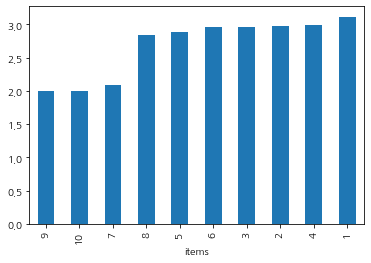

In [169]:
new_data['repeat'].groupby(new_data['items']).mean().sort_values().plot(kind='bar')
# items가 많은데 연속 편성 횟수가 작다 ? => 노출 시간이 클 거같음(60분)

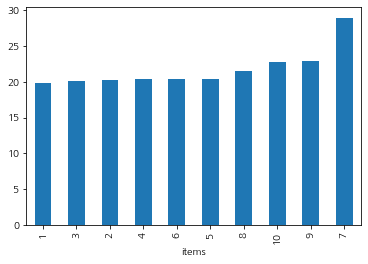

In [170]:
new_data['노출(분)'].groupby(new_data['items']).mean().sort_values().plot(kind='bar')
# 위에서 생각한대로 ! 아이템 수가 많을 수록 평균 노출(분) 시간이 길다

### 한개의 item만 방송한다면 ?!

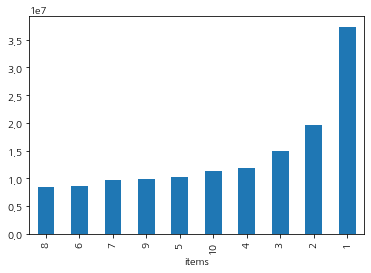

In [172]:
new_data['취급액'].groupby(new_data['items']).mean().sort_values().plot(kind='bar')
# 한번에 방송하는 아이템의 개수가 적을수록 취급액이 높다

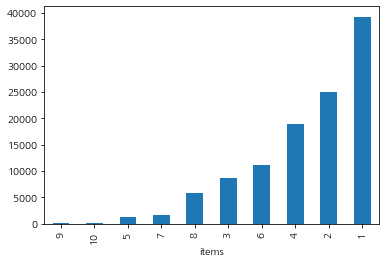

In [173]:
new_data['repeat'].groupby(new_data['items']).sum().sort_values().plot(kind='bar')
# 한개만 방송한게 진짜 월등히 높네 ?......흠

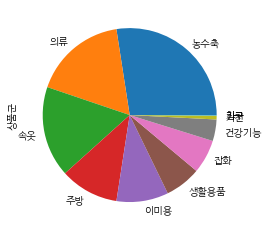

In [182]:
new_data.loc[new_data['items']==1]['상품군'].value_counts().plot(kind='pie') # 12610

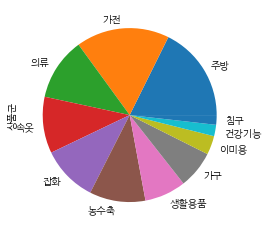

In [181]:
new_data['상품군'].value_counts().plot(kind='pie')
# 전체 중 주방, 가전 상품군이 많은 것에 비해서 농수축이 1개의 item만 방송하는 경우가 많음 !!!

### item 개수가 많은 방송은 ?
=> 가전, 가구가 월등히 높음

* 주의
item 개수가 10 개인 것에 아주 많은 것들이 포함됨
이걸......사진찍으려다가
10개에 쌀이 한갠데 들어가있는걸 발견했고
코드를 다시짜야하네 ? ....한.ㅇㄹ마ㅡ;ㅣㄴㄷㄹ즈{

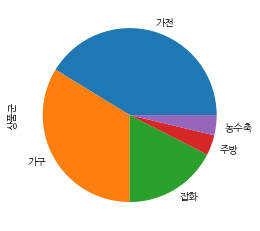

In [186]:
new_data.loc[new_data['items']==10]['상품군'].value_counts().plot(kind='pie')

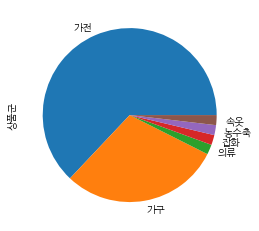

In [187]:
new_data.loc[new_data['items']==9]['상품군'].value_counts().plot(kind='pie')

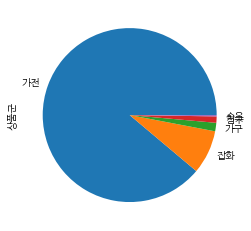

In [188]:
new_data.loc[new_data['items']==8]['상품군'].value_counts().plot(kind='pie')

# 마더코드 활용

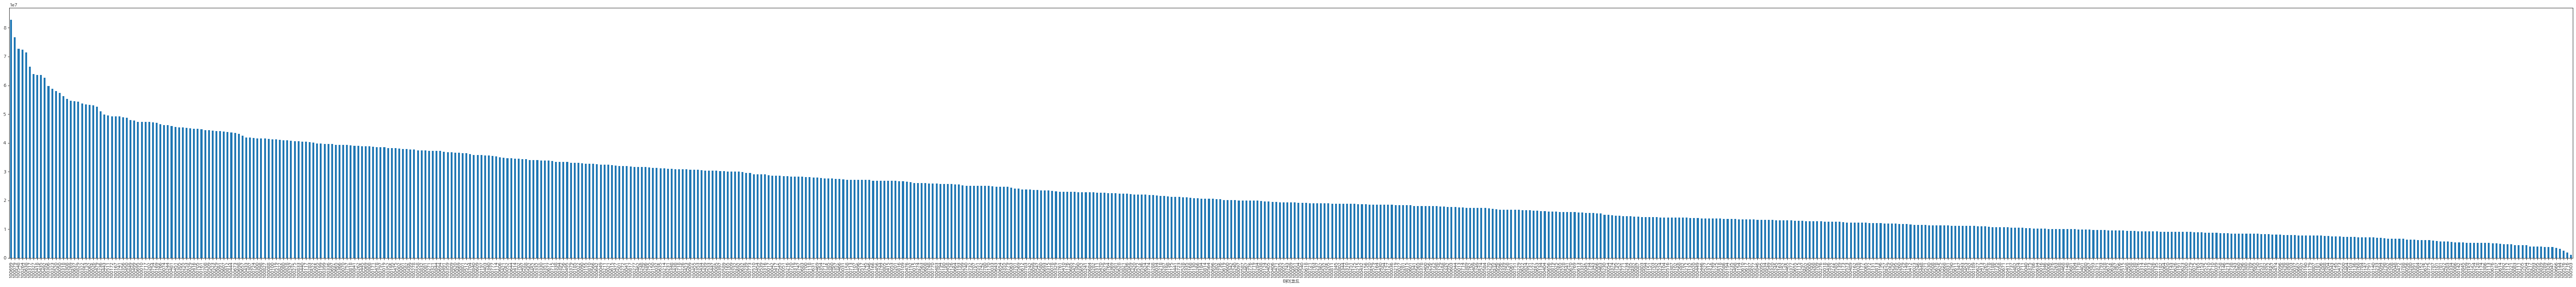

In [165]:
plt.figure(figsize=(100,5))
plt.rc('font', size=10)
new_data['취급액'].groupby(new_data['마더코드']).mean().sort_values(ascending=False).plot(kind='bar')

In [166]:
plt.figure(figsize=(100,5))
plt.rc('font', size=10)
new_data['취급액'].groupby(new_data['마더코드']).mean().sort_values(ascending=False)#.plot(kind='bar')

마더코드
100699    8.277417e+07
100079    7.666735e+07
100548    7.279163e+07
100264    7.243833e+07
100638    7.138033e+07
              ...     
100666    3.428833e+06
100144    3.143792e+06
100576    2.562278e+06
100716    1.926667e+06
100503    1.059417e+06
Name: 취급액, Length: 687, dtype: float64

<Figure size 7200x360 with 0 Axes>

In [168]:
new_data[new_data['마더코드']==100079]

,month,day,요일,hour,minute,노출(분),repeat,상품군,마더코드,상품코드,items,상품명,pay_type,판매단가,취급액/total,취급액
11909,4,26,4,13,0,30,2,속옷,100079,200215,1,아키 라이크라 노와이어 브라 컬렉션(뉴아키 23차),0,99900,0.306624,38779000
11910,4,26,4,13,30,30,2,속옷,100079,200215,1,아키 라이크라 노와이어 브라 컬렉션(뉴아키 23차),0,99900,0.693376,87692000
12168,4,28,6,24,20,30,2,속옷,100079,200215,1,아키 라이크라 노와이어 브라 컬렉션(뉴아키 23차),0,99900,0.452688,58705000
12169,4,28,6,24,50,30,2,속옷,100079,200215,1,아키 라이크라 노와이어 브라 컬렉션(뉴아키 23차),0,99900,0.547312,70976000
12428,5,1,2,20,0,30,2,속옷,100079,200215,1,아키 라이크라 노와이어 브라 컬렉션(뉴아키 23차),0,99900,0.284151,56488000
12429,5,1,2,20,30,30,2,속옷,100079,200215,1,아키 라이크라 노와이어 브라 컬렉션(뉴아키 23차),0,99900,0.715849,142308000
12515,5,2,3,14,0,30,2,속옷,100079,200215,1,아키 라이크라 노와이어 브라 컬렉션(뉴아키 23차),0,99900,0.310115,35684000
12516,5,2,3,14,30,30,2,속옷,100079,200215,1,아키 라이크라 노와이어 브라 컬렉션(뉴아키 23차),0,99900,0.689885,79383000
13098,5,6,0,23,0,30,2,속옷,100079,200215,1,아키 라이크라 노와이어 브라 컬렉션(뉴아키 23차),0,99900,0.367123,44963000
13099,5,6,0,23,30,30,2,속옷,100079,200215,1,아키 라이크라 노와이어 브라 컬렉션(뉴아키 23차),0,99900,0.632877,77511000
